In [1]:
# import itertools
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io

from collections import defaultdict
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import re
import h5py
import napari
import tifffile as tiff
import seaborn as sns
import pickle

c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
p_dir = (Path().cwd().parents[0]).absolute()

module_path = str(p_dir / "src")
 
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
data_dir = (Path().cwd().parents[0] / 'data').absolute()

df_meta_path = data_dir /'tissue'  / 'metadata' / 'imgs_reg.csv'
df_imgs = pd.read_csv(df_meta_path)


In [5]:
df_imgs = df_imgs[df_imgs.FOV == '40X']

# Test segmentation 1 FOV

In [6]:
from deepcell.applications import Mesmer
from deepcell.utils.plot_utils import make_outline_overlay

app = Mesmer()

ModuleNotFoundError: No module named 'deepcell'

In [ ]:
from skimage.exposure import match_histograms
from skimage.exposure import rescale_intensity
import tifffile as tiff
from skimage.exposure import rescale_intensity
from skimage import util

def contrast_str(img, n_min=10, n_max=100):
    p2, p98 = np.percentile(img, (n_min, n_max))
    img_rescale = rescale_intensity(img, in_range=(p2, p98))
    img_rescale = util.img_as_ubyte(img_rescale)
    return img_rescale

def make_color_overlay(input_data):
    """Create a color overlay from 2 channel image data
    
    Args:
        input_data: stack of input images
    
    Returns:
        numpy.array: color-adjusted stack of overlays in RGB mode
    """
    RGB_data = np.zeros(input_data.shape[:3] + (3, ), dtype='float32')
    
    # rescale channels to aid plotting
    for img in range(input_data.shape[0]):
        for channel in range(input_data.shape[-1]):
            # get histogram for non-zero pixels
            percentiles = np.percentile(input_data[img, :, :, channel][input_data[img, :, :, channel] > 0],
                                            [5, 95])
            rescaled_intensity = rescale_intensity(input_data[img, :, :, channel],
                                                       in_range=(percentiles[0], percentiles[1]),
                                                       out_range='float32')
            RGB_data[img, :, :, channel + 1] = rescaled_intensity
        
    # create a blank array for red channel
    return RGB_data

In [ ]:
for row in df_imgs.itertuples():
    path = row.Path
    with h5py.File(path, 'r') as f:
        markers = f['imgs'].attrs['Marker']
        imgs = f['imgs'][:]
    break

In [ ]:
postprocess_kwargs_cell = {
                'maxima_threshold': 0.02,
                'interior_threshold': 0.07,
            }

postprocess_kwargs_nuclei = {
                'maxima_threshold': 0.05,
                'interior_threshold': 0.2,
            }

In [ ]:
cyto_markers = ['CD8', 'Pan-cytokeratin', 'CD4']
markers = list(markers)

In [ ]:
img_dapi = contrast_str(imgs[13], n_min=30, n_max=99.9)
imgs_cyto = [contrast_str(imgs[markers.index(m)], n_min=10, n_max=99.5) for m in cyto_markers]
img_cyto = contrast_str(np.max(imgs_cyto, axis=0))
X_train = np.stack([img_dapi, img_cyto], axis=-1)[np.newaxis,...]
rgb_images = make_color_overlay(X_train)

In [ ]:
import napari

napari.view_image(X_train[0].transpose((2,0,1)))

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 2218.5, 5580.5), zoom=0.14009138147285433, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(1.0, 1.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=2, last_used=0, range=((0.0, 2.0, 1.0), (0.0, 4438.0, 1.0), (0.0, 11162.0, 1.0)), current_step=(1, 2219, 5581), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'Image' at 0x22729b801c0>], scale_bar=ScaleBar(visible=False, colored=False, color=array([1., 0., 1., 1.], dtype=float32), ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10.0, box=False, box_color=array([0. , 0. , 0. , 0.6], dtype=float32), unit=None), text_overlay=TextOverlay(visible=False, color=array([0.5, 0.5, 0.5, 1. ], dtype=float32), font_size=10.0, position=<TextOverlayPosition

In [ ]:
import napari

napari.view_image(imgs, name=markers, channel_axis=0, contrast_limits=[0,2**16])

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 2218.5, 5580.5), zoom=0.14009138147285433, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(1.0, 1.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=2, ndisplay=2, last_used=0, range=((0.0, 4438.0, 1.0), (0.0, 11162.0, 1.0)), current_step=(2219, 5581), order=(0, 1), axis_labels=('0', '1')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'Hoechst' at 0x2272e3c05e0>, <Image layer 'Sox2/Oct4' at 0x2272e1f16c0>, <Image layer 'NF-Kb/p-P90rsk' at 0x2272fdca8f0>, <Image layer 'Hoechst [1]' at 0x2272fe7c880>, <Image layer 'Cyclin D1/CDK4' at 0x227307a6260>, <Image layer 'TRAIL/DR5' at 0x22730831300>, <Image layer 'Hoechst [2]' at 0x227308e65f0>, <Image layer 'p-ERK/c-MYC' at 0x227309907c0>, <Image layer 'Hoechst [3]' at 0x22730a1e980>, <Image layer 'Cyclin E/CDK2' at 0x2272ac14b50>,

## Examples

In [ ]:
for row in df_imgs.itertuples():
    path = row.Path
    with h5py.File(path, 'r') as f:
        markers = f['imgs'].attrs['Marker']
        imgs = f['imgs'][:]
    break

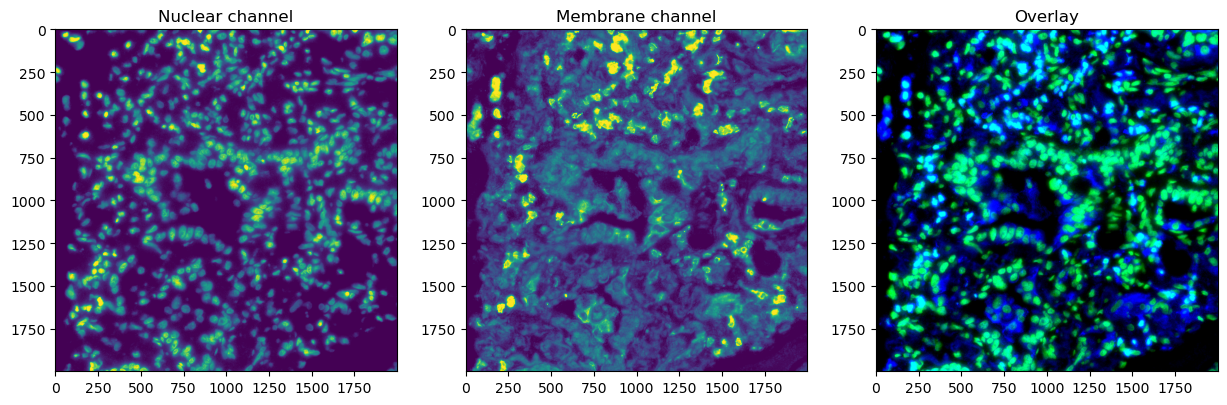

In [ ]:
idx = 0 
x_max = 2000
y_max = 2000

fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(X_train[idx, :y_max, :x_max, 0])
ax[1].imshow(X_train[idx, :y_max, :x_max, 1])
ax[2].imshow(rgb_images[idx, :y_max, :x_max])

ax[0].set_title('Nuclear channel')
ax[1].set_title('Membrane channel')
ax[2].set_title('Overlay')

plt.show()

In [ ]:
segmentation_predictions = app.predict(X_train[:, :y_max, :x_max, :], image_mpp=0.188, compartment='both', postprocess_kwargs_whole_cell=postprocess_kwargs_cell, postprocess_kwargs_nuclear=postprocess_kwargs_nuclei)


In [ ]:
overlay_data = make_outline_overlay(rgb_data=rgb_images[:,:y_max, :x_max,:], predictions=segmentation_predictions[...,:1])
overlay_data_nuc = make_outline_overlay(rgb_data=rgb_images[:,:y_max, :x_max,:], predictions=segmentation_predictions[...,1:])

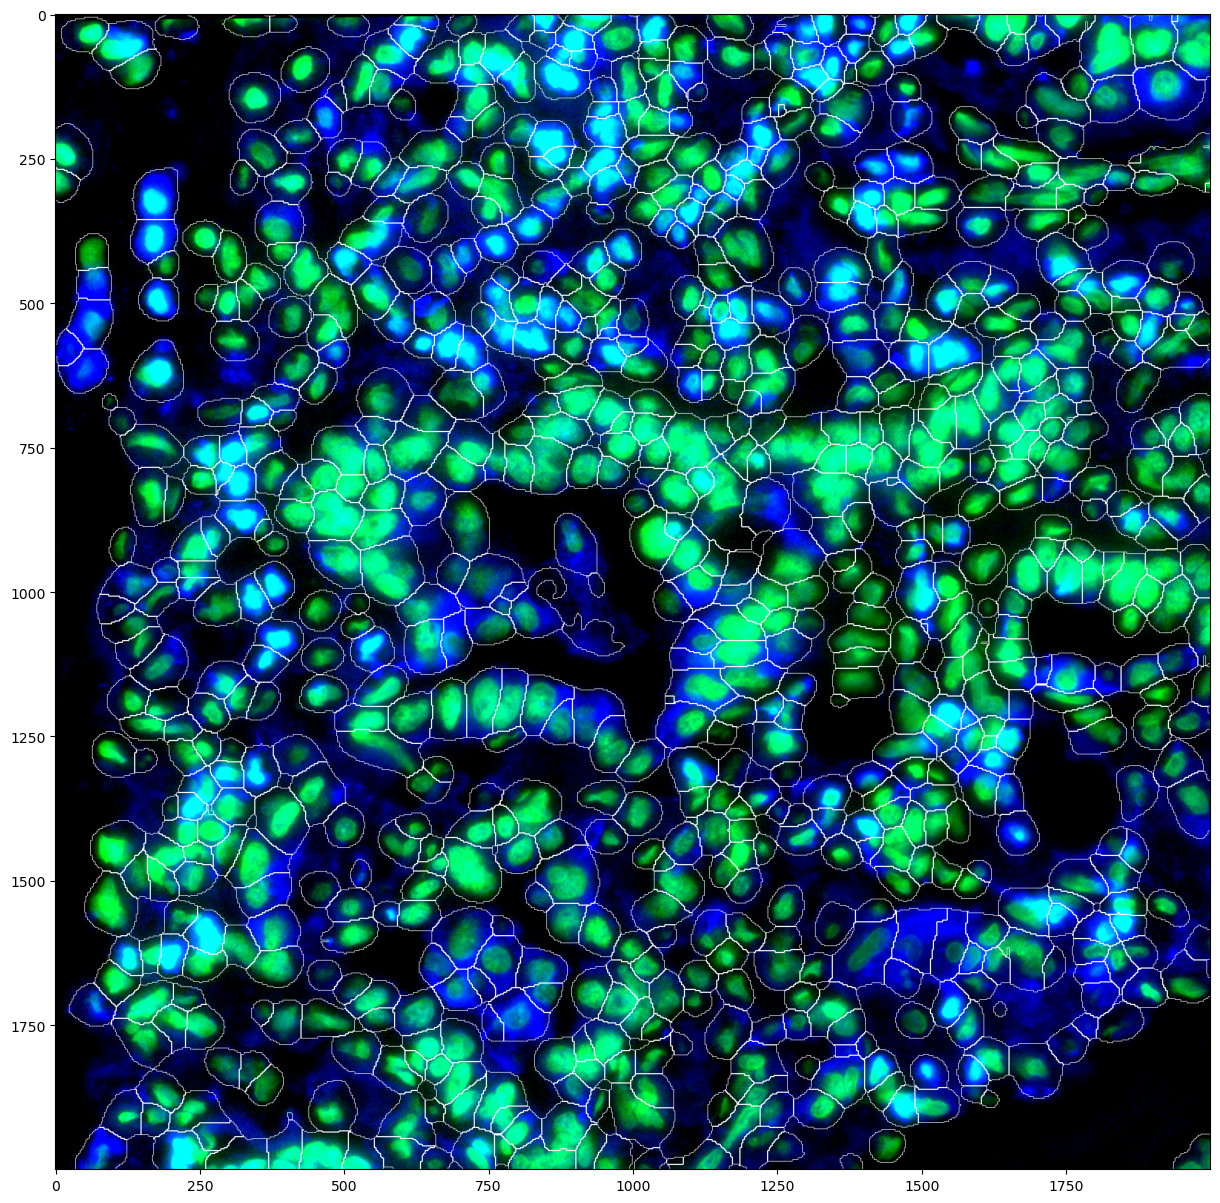

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(overlay_data[idx, ...])
plt.show()

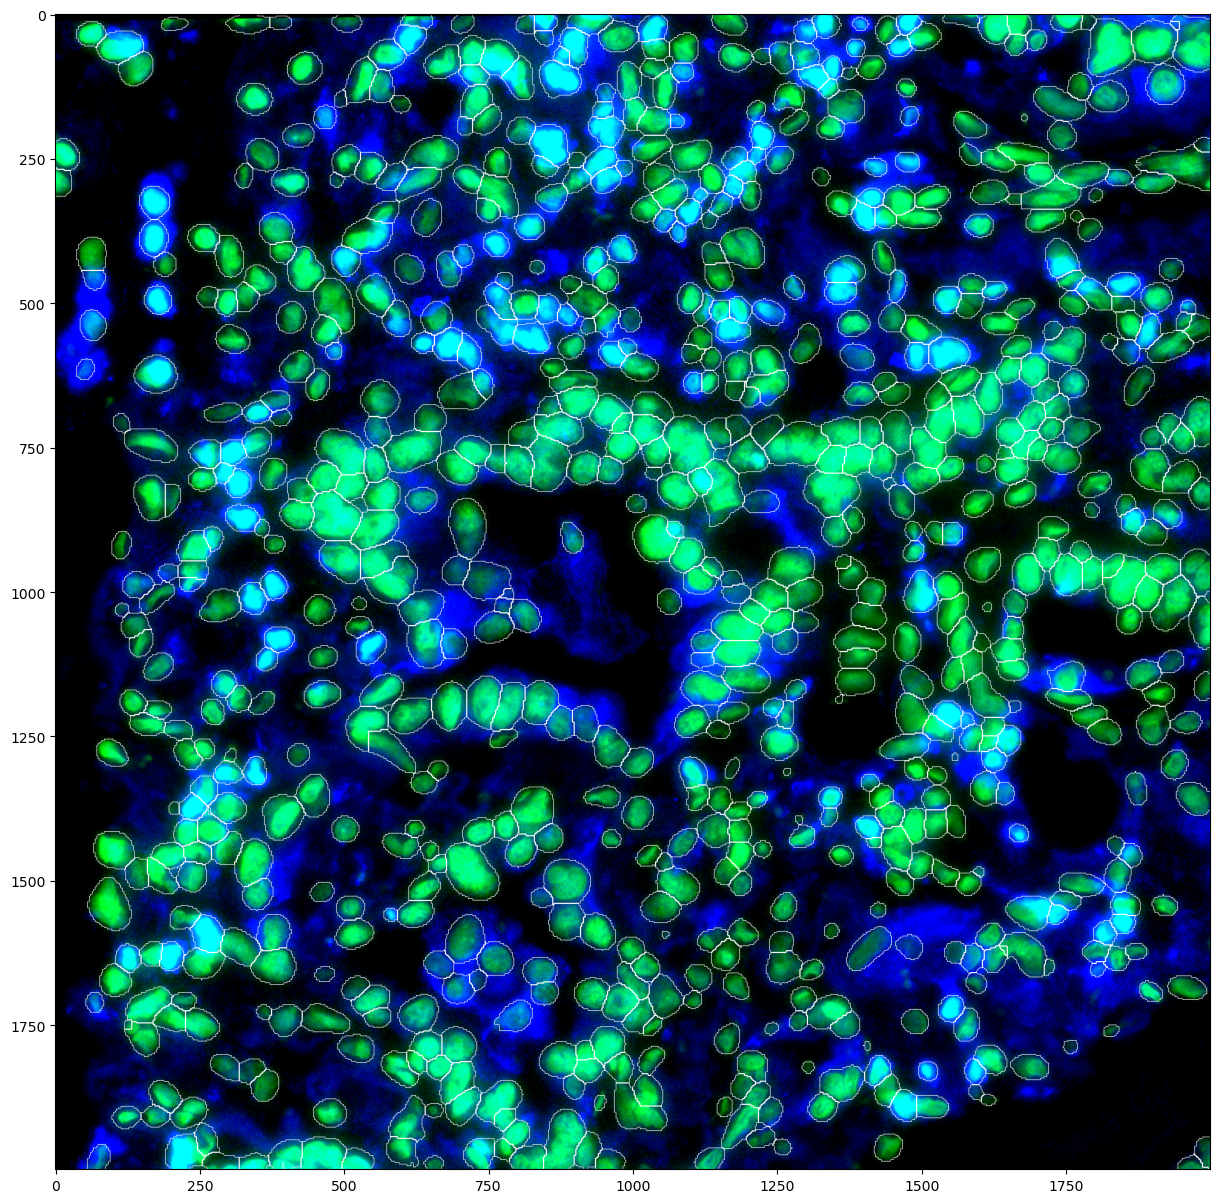

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(overlay_data_nuc[idx, ...])
plt.show()

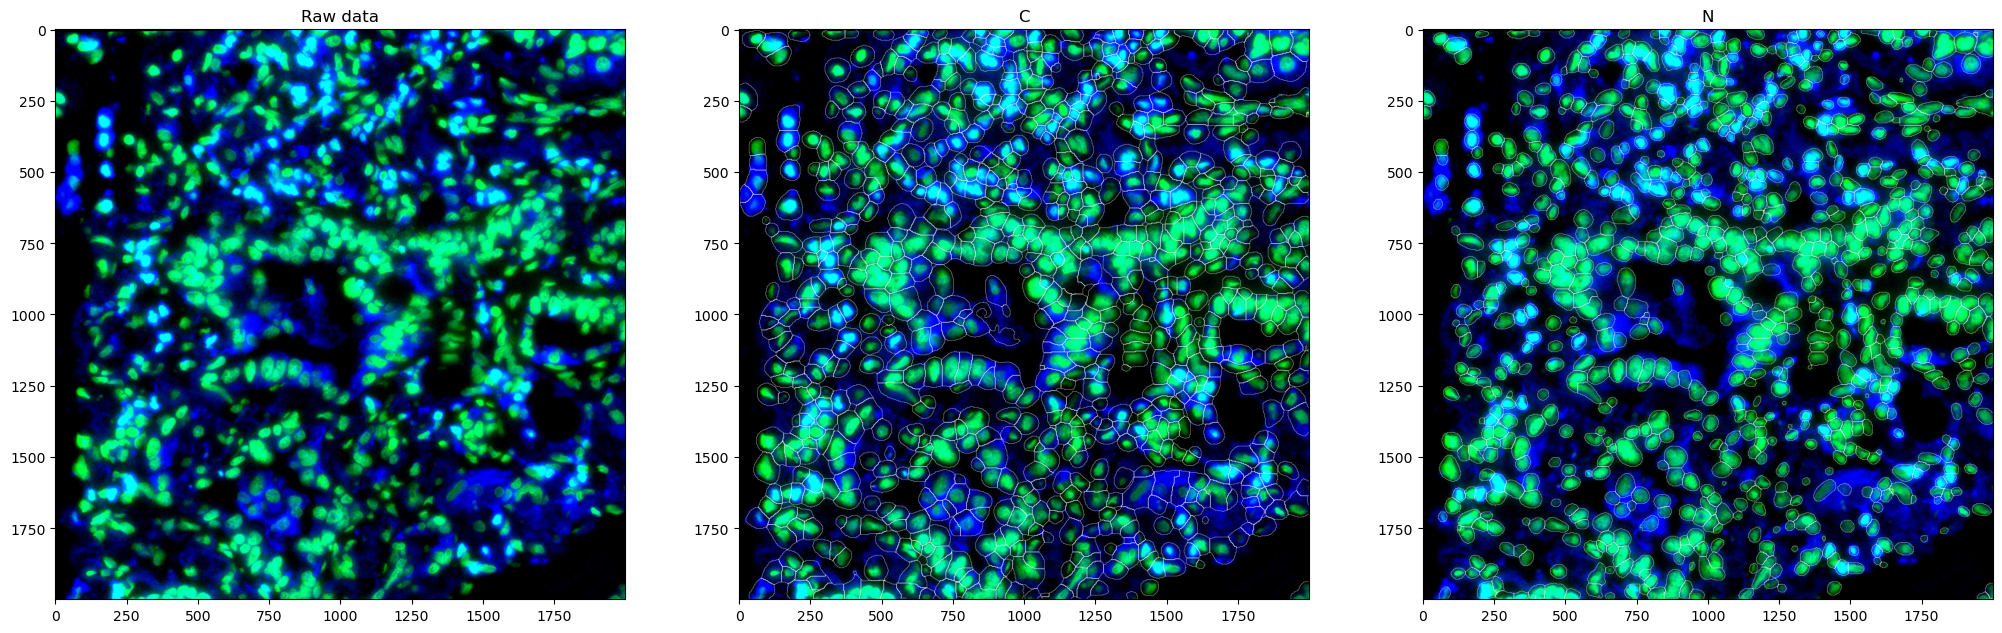

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(25, 15))
ax[0].imshow(rgb_images[idx,:y_max, :x_max,:],)
ax[1].imshow(overlay_data[idx, ...])
ax[2].imshow(overlay_data_nuc[idx, ...])
ax[0].set_title('Raw data')
ax[1].set_title('C')
ax[2].set_title('N')
plt.show()

# Loop

In [ ]:
mask_path = data_dir /'tissue' /'masks'

In [ ]:
for row in df_imgs.itertuples():
    dataset = row.Condition
    # Read images for
    path = row.Path
    with h5py.File(path, 'r') as f:
        markers = f['imgs'].attrs['Marker']
        imgs = f['imgs'][:]
        
    markers = list(markers)
    # Get images    
    img_dapi = contrast_str(imgs[13], n_min=30, n_max=99.9)
    imgs_cyto = [contrast_str(imgs[markers.index(m)], n_min=10, n_max=99.5) for m in cyto_markers]
    img_cyto = contrast_str(np.max(imgs_cyto, axis=0))
    X_train = np.stack([img_dapi, img_cyto], axis=-1)[np.newaxis,...]
    rgb_images = make_color_overlay(X_train)

    # Segmentation
    segmentation_predictions = app.predict(X_train, image_mpp=0.188, compartment='both', postprocess_kwargs_whole_cell=postprocess_kwargs_cell, postprocess_kwargs_nuclear=postprocess_kwargs_nuclei)

    # Save mask
    save_path = mask_path / f'{row.Condition}_cell.png'
    skimage.io.imsave(save_path, segmentation_predictions[0,...,0])
    save_path = mask_path / f'{row.Condition}_nuclei.png'
    skimage.io.imsave(save_path, segmentation_predictions[0,...,1])


C:\Users\thu71\AppData\Local\Temp\ipykernel_85876\656032931.py:22: UserWarning: \\bme-retromaster.ad.gatech.edu\labs5\coskun-lab\Thomas\23_PLA_revision\data\tissue\masks\577-1197_cell.png is a low contrast image
  skimage.io.imsave(save_path, segmentation_predictions[0,...,0])
C:\Users\thu71\AppData\Local\Temp\ipykernel_85876\656032931.py:24: UserWarning: \\bme-retromaster.ad.gatech.edu\labs5\coskun-lab\Thomas\23_PLA_revision\data\tissue\masks\577-1197_nuclei.png is a low contrast image
  skimage.io.imsave(save_path, segmentation_predictions[0,...,1])
C:\Users\thu71\AppData\Local\Temp\ipykernel_85876\656032931.py:22: UserWarning: \\bme-retromaster.ad.gatech.edu\labs5\coskun-lab\Thomas\23_PLA_revision\data\tissue\masks\577-1210_cell.png is a low contrast image
  skimage.io.imsave(save_path, segmentation_predictions[0,...,0])
C:\Users\thu71\AppData\Local\Temp\ipykernel_85876\656032931.py:24: UserWarning: \\bme-retromaster.ad.gatech.edu\labs5\coskun-lab\Thomas\23_PLA_revision\data\tissue\

# Visualization

In [ ]:
# Define HE path 
HE_dir = data_dir / 'tissue' / 'HE_registered'

# Define mask folder
mask_dir = data_dir /'tissue' /'masks'

# Loop through mask folder to get
masks_path = defaultdict(dict) 
for path in os.listdir(mask_dir):
    name = path.split('.')[0]
    if 'nuclei' in name:
        masks_path[name[:-7]]['nuclei'] = mask_dir / path
    elif 'cell' in name:
        masks_path[name[:-5]]['cell'] =mask_dir / path    
    else:
        pass

masks_path

defaultdict(dict,
            {'577-1197': {'cell': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/tissue/masks/577-1197_cell.png'),
              'nuclei': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/tissue/masks/577-1197_nuclei.png')},
             '577-1210': {'cell': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/tissue/masks/577-1210_cell.png'),
              'nuclei': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/tissue/masks/577-1210_nuclei.png')}})

In [ ]:
dfs = []

for row in df_imgs.itertuples():
    # Get info
    path = row.Path
    name = '_'.join(row[1:3])
    dataset = row.Condition

    # Read images for
    path = row.Path
    with h5py.File(path, 'r') as f:
        markers = f['imgs'].attrs['Marker']
        imgs = f['imgs'][:]

    # Read mask
    mask = skimage.io.imread(masks_path[dataset]['cell'])

    # Read HE image
    HE_path = HE_dir / f'{name}.tif'
    HE_img = tiff.imread(HE_path)

    # Extract single-cell information
    
    break

In [ ]:
viewer = napari.view_image(imgs, name=markers, channel_axis=0, contrast_limits=[0,2**16], visible=False)
viewer.add_image(HE_img, visible=False)
viewer.add_labels(mask)

<Labels layer 'mask' at 0x1cf236a4dd0>